# Prerequisites

If you are using google colab, first run the check version below to connect the VM. After that use the `ctrl+shift+P` then type "`use fallback runtime version`"  to roll back to Python 3.9.16 runtime. It will reset the connection and then run the check version again.

This due to the library used in this model, the TFLite Model Maker, has an issue with python 3.10 or above that makes an infinite download when installing the library

In [ ]:
!python3 --version

## Install the required library and packages

In [ ]:
!pip install -q pycocotools
!pip install -q opencv-contrib-python-headless
!pip install -q tflite-model-maker
!pip install -q tensorflow

Then after the install, import the library and the packages. If there's an error, try rerun the code

In [ ]:
import numpy as np
import os
import shutil
import cv2
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from google.colab import drive, files
from google.colab.patches import cv2_imshow

import xml.etree.ElementTree as ET
import tensorflow as tf

assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

# Preparing the Data

Dataset is image of food ingredients. This is used for the object detection. For more information on the dataset, see [Here.](https://clever-spectrum-138.notion.site/Data-Source-For-Snapcook-Machine-Learning-Model-d3cf68f0e570469dac092c6b4a6f8658)



## GDrive Mount

Mount your Google Drive because we are gonna download the dataset from GDrive. Here some tutorial for mounting gdrive to colabs [Here.](https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a), or just run the code below

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


## Download Dataset

Download the already customized data from GDrive.

In [ ]:
!gdown 16tZQY8yVJ1cXaodYo3vPzFiWm4IeBL79 #dataset id#

Downloading...
From: https://drive.google.com/uc?id=16tZQY8yVJ1cXaodYo3vPzFiWm4IeBL79
To: /content/dataset.zip
100% 113M/113M [00:01<00:00, 107MB/s]


After downloading the data, extrac it.

In [ ]:
!unzip /content/dataset.zip #datalocation#

Streaming output truncated to the last 5000 lines.
  inflating: dataset/chicken/train/-26_jpg.rf.893b683b029f18335aed7fa52f200e4a.jpg  
  inflating: dataset/chicken/train/-26_jpg.rf.893b683b029f18335aed7fa52f200e4a.xml  
  inflating: dataset/chicken/train/-274_jpg.rf.be50ae8ed99610481164ba481e3a506a.jpg  
  inflating: dataset/chicken/train/-274_jpg.rf.be50ae8ed99610481164ba481e3a506a.xml  
  inflating: dataset/chicken/train/-28_jpg.rf.fc106809082986153dac51ce2dee530d.jpg  
  inflating: dataset/chicken/train/-28_jpg.rf.fc106809082986153dac51ce2dee530d.xml  
  inflating: dataset/chicken/train/-29_jpg.rf.170677850f0ab961872ab7244691d5fa.jpg  
  inflating: dataset/chicken/train/-29_jpg.rf.170677850f0ab961872ab7244691d5fa.xml  
  inflating: dataset/chicken/train/-29_jpg.rf.6ecfd1b92232fa24fbdcf5d0ba475bc3.jpg  
  inflating: dataset/chicken/train/-29_jpg.rf.6ecfd1b92232fa24fbdcf5d0ba475bc3.xml  
  inflating: dataset/chicken/train/-29_jpg.rf.715644d1db4549b392f8ff094f2e7d09.jpg  
  inflating:

```
├───/dataset
│   ├───/potato
│   ├───/carrot
│   ├───/Tempe
│   ├───/Fruit
│   ├───/chicken
│   ├───/tomato
│   ├───/Daging sapi
│   ├───/cabbage
│   ├───/test
```



In [ ]:
DATASET_PATH = '/content/dataset'
ALL_DATASET_PATH = '/content/all_dataset'

## Combine Data

Next you need to do is to combine all that folder into one dataset folder, where it contains 2 folder, train and valid

In [ ]:
#get all path on the folder
def get_all_folder(path, folder):
    items = os.listdir(path)
    invalid_data = ['tomato', 'test']
    folder_names = [os.path.join(path, item, folder) for item in items if item not in invalid_data]
    return folder_names

In [ ]:
def copy_files(source_folder, files, target_folder):
    for file in files:
        source_path = os.path.join(source_folder, file)
        target_path = os.path.join(target_folder, file)
        shutil.copy(source_path, target_path)

def combine_files(folders, target_folder):
    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    for folder in folders:
        if os.path.exists(folder):
            files = os.listdir(folder)
            copy_files(folder, files, target_folder)
        else:
            print(f"Folder {folder} tidak ditemukan.")


In [ ]:
train_folders = get_all_folder(DATASET_PATH, 'train')
valid_folders = get_all_folder(DATASET_PATH, 'valid')

print("Train folder paths:")
total_train = 0
for folder_name in train_folders:
    files = os.listdir(folder_name)
    total_train += len(files)
    print(folder_name)

print("\nValid folder paths:")
for folder_name in valid_folders:
    print(folder_name)

print("total_train img/xml"+str(total_train))

Train folder paths:
/content/dataset/cabbage/train
/content/dataset/chicken/train
/content/dataset/carrot/train
/content/dataset/Daging sapi/train
/content/dataset/potato/train
/content/dataset/Fruit/train
/content/dataset/Tempe/train
/content/dataset/egg/train

Valid folder paths:
/content/dataset/cabbage/valid
/content/dataset/chicken/valid
/content/dataset/carrot/valid
/content/dataset/Daging sapi/valid
/content/dataset/potato/valid
/content/dataset/Fruit/valid
/content/dataset/Tempe/valid
/content/dataset/egg/valid
total_train img/xml5536


In [ ]:
all_train_folder = os.path.join(ALL_DATASET_PATH, 'train') # train
all_valid_folder = os.path.join(ALL_DATASET_PATH, 'valid') # Vald

In [ ]:
# combine to all data valid folder
combine_files(folders=valid_folders, target_folder=all_valid_folder)

In [ ]:
# combine to all data train folder
combine_files(folders=train_folders, target_folder=all_train_folder)

In [ ]:
valid_files = os.listdir(all_valid_folder)
train_files = os.listdir(all_train_folder)

img_files = [file for file in valid_files if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
xml_files = [file for file in valid_files if file.lower().endswith(('.xml'))]
print("IMG valid count: {}".format(len(img_files)))
print("XML valid count: {}".format(len(xml_files)))

img_train_files = [file for file in train_files if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
xml_train_files = [file for file in train_files if file.lower().endswith(('.xml'))]
print("IMG train count: {}".format(len(img_train_files)))
print("XML train count: {}".format(len(xml_train_files)))

IMG valid count: 688
XML valid count: 688
IMG train count: 2768
XML train count: 2768




```
# Expected
IMG valid count: 688
XML valid count: 688
IMG train count: 2768
XML train count: 2768
```



## 📊Exploratory Data Analysis

In [ ]:
def read_xml(xml_file):
    with open(xml_file, 'r') as f:
        xml_data = f.read()
    soup = BeautifulSoup(xml_data, 'xml')
    objects = soup.find_all('object')
    data = []
    for obj in objects:
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        data.append((name, (xmin, ymin, xmax, ymax)))
    return data

In [ ]:
def visualize_bbox(image_file, xml_file):
    data = read_xml(xml_file)
    img = cv2.imread(image_file)
    if img is None:
        print(f"Failed to load image: {image_file}")
        return
    for name, bbox in data:
        xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    return img

In [ ]:
def visualize_multiple_bboxes(folder_directory, num_images):
    image_files = []
    for file_name in os.listdir(folder_directory):
        if file_name.lower().endswith(('.jpg', '.jpeg')):
            image_files.append(file_name)

    selected_image_files = image_files[:num_images]

    num_cols = min(num_images, 5)
    num_rows = -(-num_images // 5)  # Pembagian ke atas (ceil division)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
    axes = axes.flatten()

    for i, image_file in enumerate(selected_image_files):
        xml_file = os.path.join(folder_directory, image_file[:-4] + '.xml')
        if os.path.isfile(xml_file):
            img = visualize_bbox(os.path.join(folder_directory, image_file), xml_file)
            if img is not None:
                axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                axes[i].axis('off')

    # Menghilangkan subplots yang tidak digunakan
    for j in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



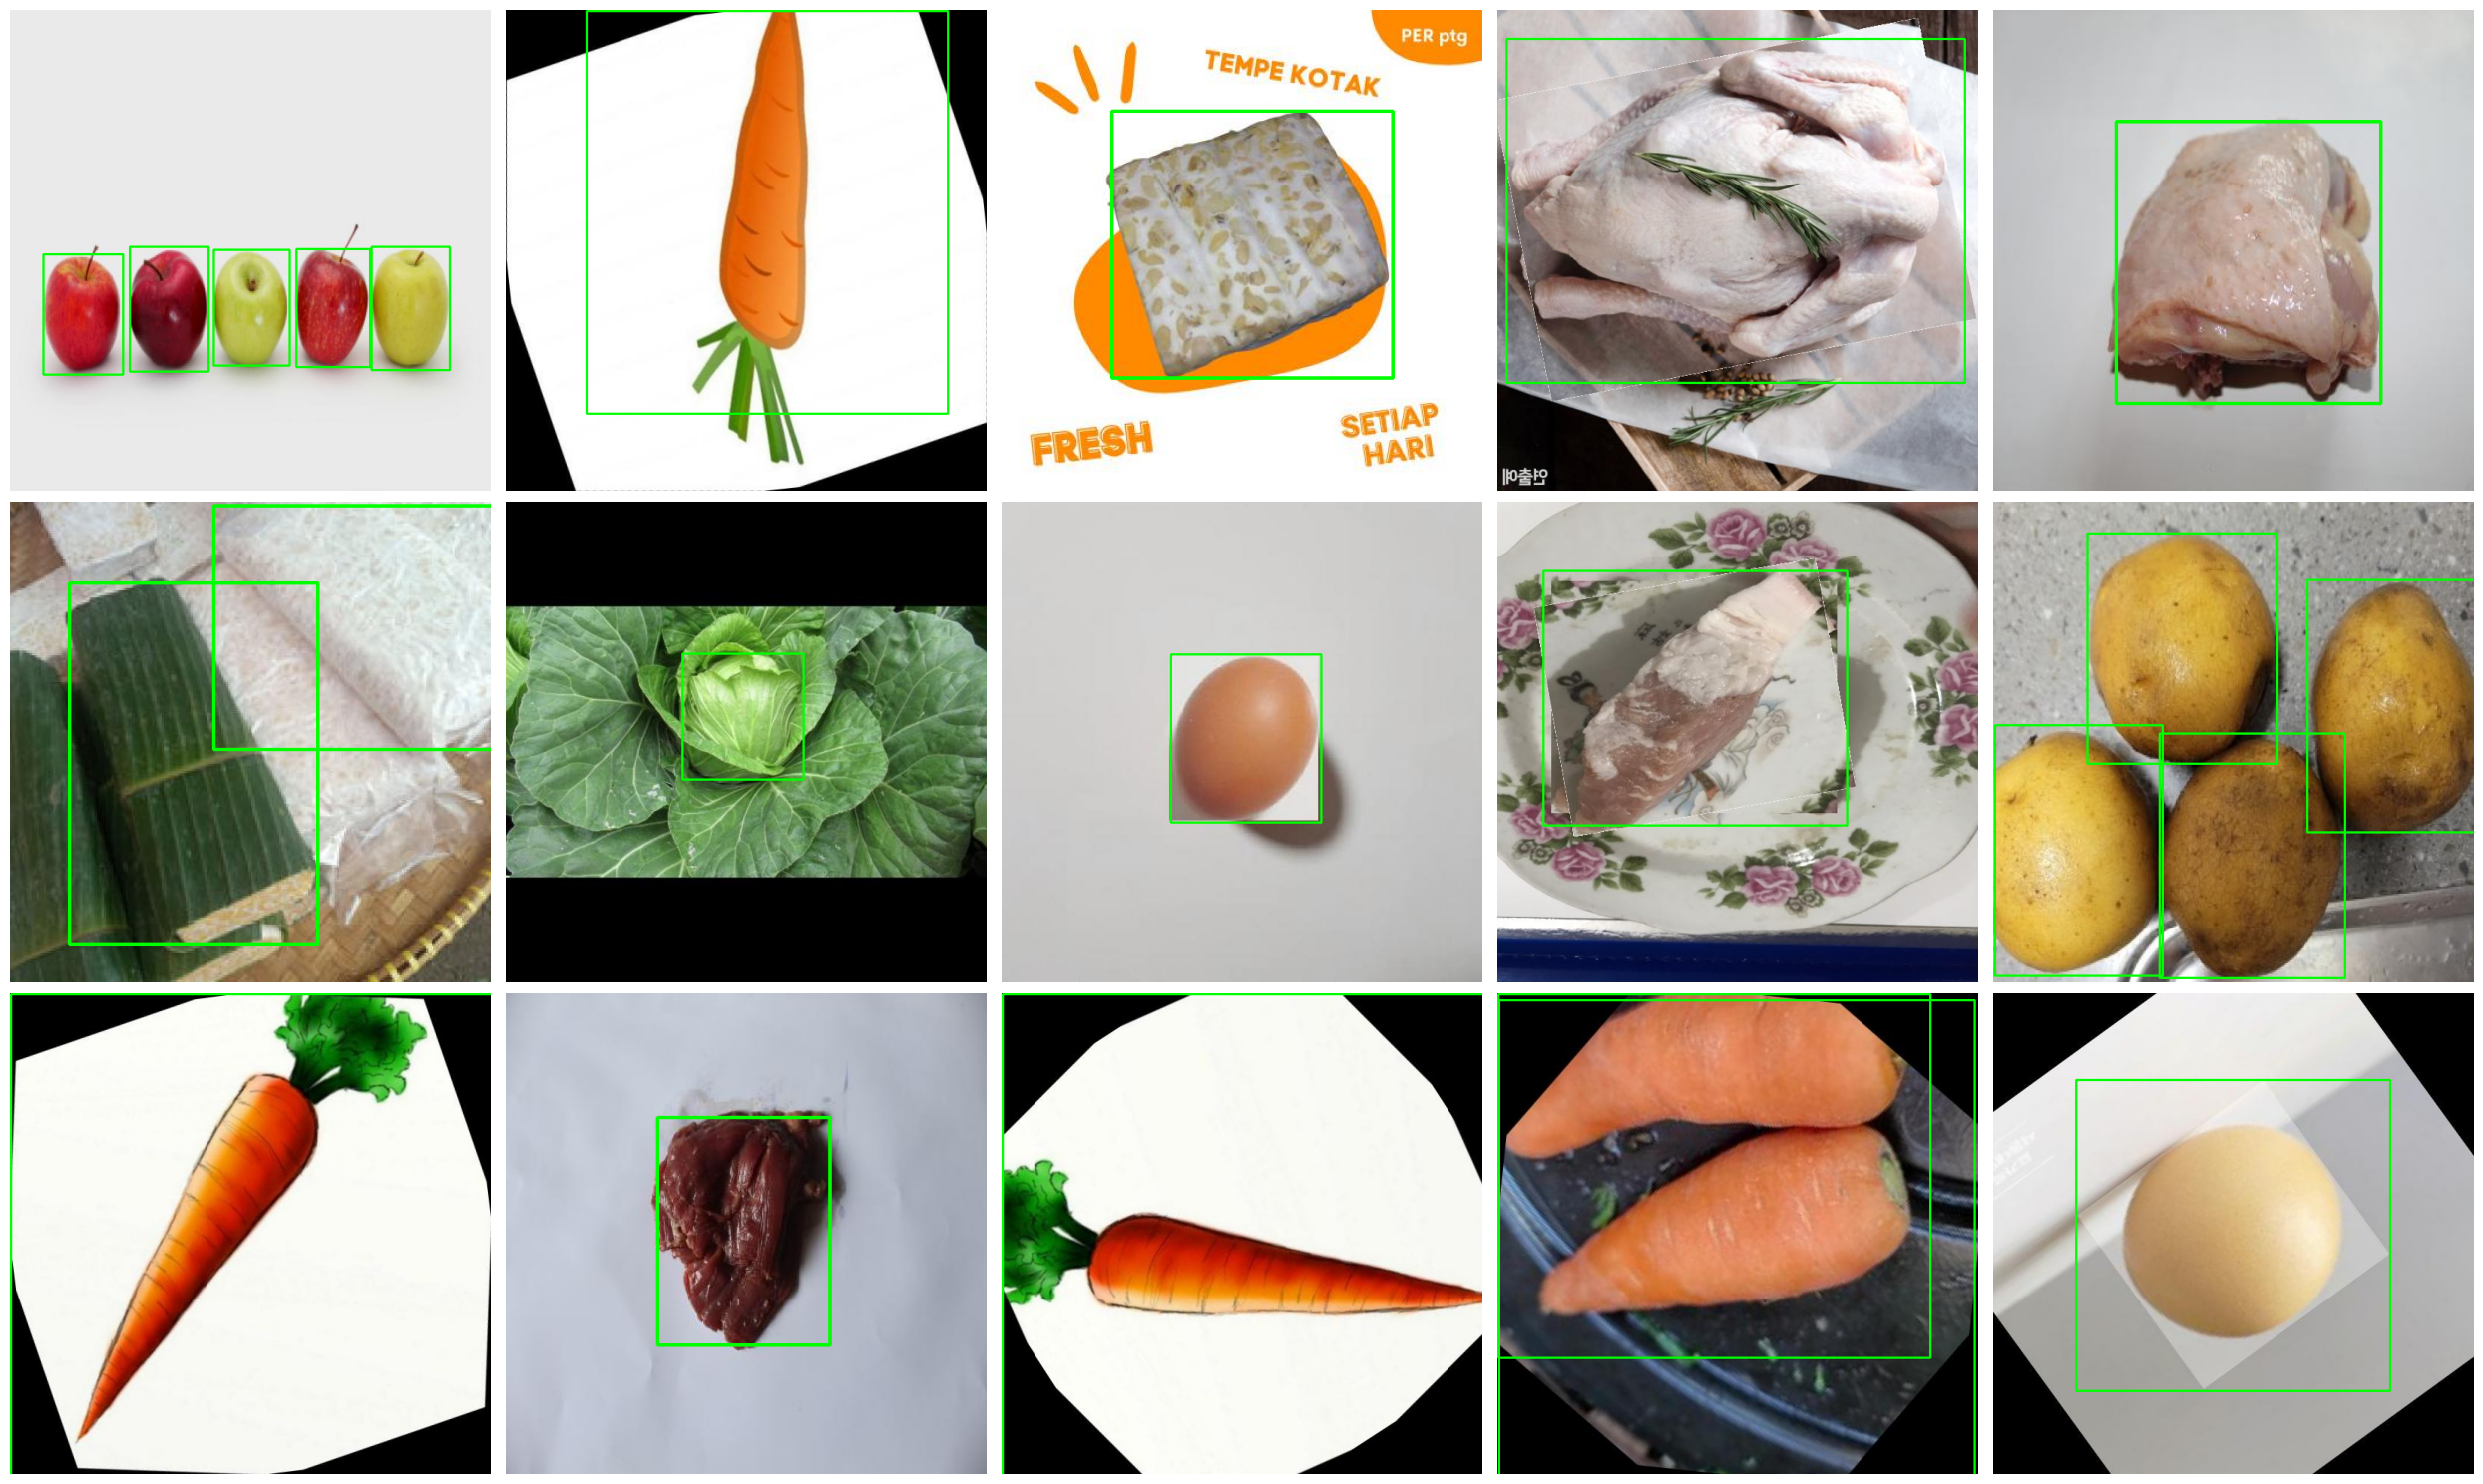

In [ ]:
folder_directory = os.path.join(ALL_DATASET_PATH,'train')
visualize_multiple_bboxes(folder_directory, num_images=15)

## Load the dataset

In [ ]:
# Class annotation
classes = ['Tempe', 'Daging sapi', 'carrot', 'apple', 'banana', 'orange', 'egg', 'potato', 'chicken', 'cabbage']

img_files = [file for file in os.listdir(all_valid_folder) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
xml_files = [file for file in os.listdir(all_valid_folder) if file.lower().endswith(('.xml'))]
print("\nIMG valid count: {}".format(len(img_files)))
print("XML valid count: {}".format(len(xml_files)))

img_train_files = [file for file in os.listdir(all_train_folder) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
xml_train_files = [file for file in os.listdir(all_train_folder) if file.lower().endswith(('.xml'))]
print("\nIMG train count: {}".format(len(img_train_files)))
print("XML train count: {}".format(len(xml_train_files)))


IMG valid count: 688
XML valid count: 688

IMG train count: 2768
XML train count: 2768


In [ ]:
# Load train and validation dataset
train_data = object_detector.DataLoader.from_pascal_voc(
    all_train_folder,
    all_train_folder,
    classes
)

val_data = object_detector.DataLoader.from_pascal_voc(
    all_valid_folder,
    all_valid_folder,
    classes
)

In [ ]:
print("There's {} images on train dataset".format(len(train_data)))
print("There's {} images on validation dataset".format(len(val_data)))

There's 2768 images on train dataset
There's 688 images on validation dataset




```
# Expect
There's 2768 images on train dataset
There's 688 images on validation dataset
```







## Data Information

In [ ]:
import xml.etree.ElementTree as ET

folder_path = all_train_dir
# Mendapatkan daftar file dalam folder
files = os.listdir(folder_path)

# Dictionary untuk melacak jumlah setiap kelas
class_counts = {}
file = ""
try:
  # Memproses setiap file XML dalam folder
  for file_name in files:
      if file_name.endswith(".xml"):
          file = file_name
          file_path = os.path.join(folder_path, file_name)
          tree = ET.parse(file_path)
          root = tree.getroot()

          # Mengakses kelas dalam file XML
          for obj in root.findall('object'):
              class_name = obj.find('name').text

              # Memperbarui jumlah kelas dalam dictionary
              if class_name in class_counts:
                  class_counts[class_name] += 1
              else:
                  class_counts[class_name] = 1
except:
  print(file_name)
  
# Menampilkan jumlah setiap kelas
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, size: {count}")

Class: egg, size: 1377
Class: orange, size: 540
Class: apple, size: 519
Class: banana, size: 309
Class: Daging sapi, size: 296
Class: Tempe, size: 465
Class: potato, size: 777
Class: carrot, size: 693
Class: chicken, size: 600
Class: cabbage, size: 340


```
# Expect
Class: egg, size: 1377
Class: orange, size: 540
Class: apple, size: 519
Class: banana, size: 309
Class: Daging sapi, size: 296
Class: Tempe, size: 465
Class: potato, size: 777
Class: carrot, size: 693
Class: chicken, size: 600
Class: cabbage, size: 340
```







# Train Model

## Create Model Spec

In [ ]:
spec = model_spec.get('efficientdet_lite2')
spec.config.learning_rate = 0.1

print(spec.__dict__)

{'model_name': 'efficientdet-lite2', 'uri': 'https://tfhub.dev/tensorflow/efficientdet/lite2/feature-vector/1', 'batch_size': 64, 'ds_strategy': <tensorflow.python.distribute.one_device_strategy.OneDeviceStrategy object at 0x7f1ca31d4a00>, 'config': {'name': 'efficientdet-lite2', 'act_type': 'relu6', 'image_size': (448, 448), 'target_size': None, 'input_rand_hflip': True, 'jitter_min': 0.1, 'jitter_max': 2.0, 'autoaugment_policy': None, 'grid_mask': False, 'sample_image': None, 'map_freq': 5, 'num_classes': 90, 'seg_num_classes': 3, 'heads': ['object_detection'], 'skip_crowd_during_training': True, 'label_map': None, 'max_instances_per_image': 100, 'regenerate_source_id': False, 'min_level': 3, 'max_level': 7, 'num_scales': 3, 'aspect_ratios': [1.0, 2.0, 0.5], 'anchor_scale': 3.0, 'is_training_bn': True, 'momentum': 0.9, 'optimizer': 'sgd', 'learning_rate': 0.1, 'lr_warmup_init': 0.008, 'lr_warmup_epoch': 1.0, 'first_lr_drop_epoch': 200.0, 'second_lr_drop_epoch': 250.0, 'poly_lr_power'

## Train

In [ ]:
model = object_detector.create(train_data, model_spec=spec, batch_size=20, train_whole_model=True, epochs=30, validation_data=val_data)

Epoch 1/30
138/138 [==============================] - 217s 1s/step - det_loss: 1.2772 - cls_loss: 0.9464 - box_loss: 0.0066 - reg_l2_loss: 0.0774 - loss: 1.3546 - learning_rate: 0.0196 - gradient_norm: 1.9738 - val_det_loss: 1.0572 - val_cls_loss: 0.8348 - val_box_loss: 0.0044 - val_reg_l2_loss: 0.0778 - val_loss: 1.1351
Epoch 2/30
138/138 [==============================] - 162s 1s/step - det_loss: 0.6380 - cls_loss: 0.4484 - box_loss: 0.0038 - reg_l2_loss: 0.0785 - loss: 0.7165 - learning_rate: 0.0310 - gradient_norm: 2.4520 - val_det_loss: 0.8601 - val_cls_loss: 0.6312 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.0792 - val_loss: 0.9392
Epoch 3/30
138/138 [==============================] - 162s 1s/step - det_loss: 0.5385 - cls_loss: 0.3763 - box_loss: 0.0032 - reg_l2_loss: 0.0796 - loss: 0.6182 - learning_rate: 0.0307 - gradient_norm: 2.2887 - val_det_loss: 1.1553 - val_cls_loss: 0.8795 - val_box_loss: 0.0055 - val_reg_l2_loss: 0.0803 - val_loss: 1.2356
Epoch 4/30
138/138 [===========

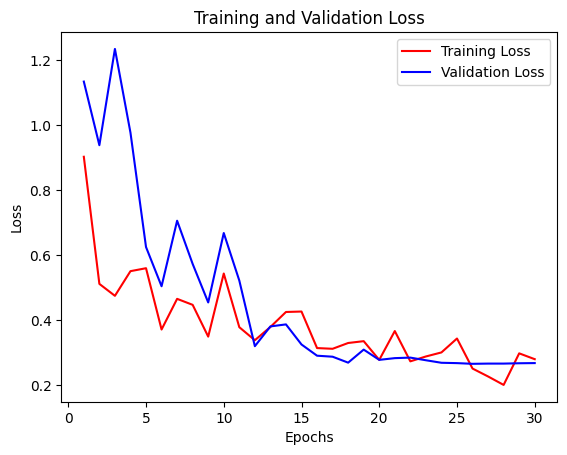

In [ ]:
#Making plot history of model
history = model.model.history

# Plotting the loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

Evaluate trained model

In [ ]:
model.evaluate(val_data)

11/11 [==============================] - 71s 3s/step



{'AP': 0.715726,
 'AP50': 0.9329715,
 'AP75': 0.80489415,
 'APs': 0.1,
 'APm': 0.6222817,
 'APl': 0.73177695,
 'ARmax1': 0.43510985,
 'ARmax10': 0.7676797,
 'ARmax100': 0.81370944,
 'ARs': 0.7,
 'ARm': 0.7166149,
 'ARl': 0.8217233,
 'AP_/Tempe': 0.5314656,
 'AP_/Daging sapi': 0.5386729,
 'AP_/carrot': 0.6993427,
 'AP_/apple': 0.7433334,
 'AP_/banana': 0.68470633,
 'AP_/orange': 0.79407626,
 'AP_/egg': 0.7870616,
 'AP_/potato': 0.84794,
 'AP_/chicken': 0.82656026,
 'AP_/cabbage': 0.7041012}

```
# AP from the latest train model

{'AP': 0.715726,
 'AP50': 0.9329715,
 'AP75': 0.80489415,
 'APs': 0.1,
 'APm': 0.6222817,
 'APl': 0.73177695,
 'ARmax1': 0.43510985,
 'ARmax10': 0.7676797,
 'ARmax100': 0.81370944,
 'ARs': 0.7,
 'ARm': 0.7166149,
 'ARl': 0.8217233,
 'AP_/Tempe': 0.5314656,
 'AP_/Daging sapi': 0.5386729,
 'AP_/carrot': 0.6993427,
 'AP_/apple': 0.7433334,
 'AP_/banana': 0.68470633,
 'AP_/orange': 0.79407626,
 'AP_/egg': 0.7870616,
 'AP_/potato': 0.84794,
 'AP_/chicken': 0.82656026,
 'AP_/cabbage': 0.7041012}
```



Then export the model. It may takes a while

In [ ]:
model.export(export_dir='.', export_format=[ExportFormat.SAVED_MODEL, ExportFormat.TFLITE])

**(Optional)** You can try to evaluate the exported model. Keep in mind that this process takes more time and resources

In [ ]:
model.evaluate_tflite('snapcook.tflite', val_data)

# Test the model

## Load the model

In [ ]:
import cv2
import tensorflow as tf
from PIL import Image

model_path = 'model.tflite'

classes = ['Tempe', 'Daging sapi', 'carrot', 'apple', 'banana', 'orange', 'egg', 'potato', 'chicken', 'cabbage']
# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  resized_img = tf.cast(resized_img, dtype=tf.uint8)
  return resized_img, original_image


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""

  signature_fn = interpreter.get_signature_runner()

  # Feed the input image to the model
  output = signature_fn(images=image)

  # Get all outputs from the model
  count = int(np.squeeze(output['output_0']))
  scores = np.squeeze(output['output_1'])
  classes = np.squeeze(output['output_2'])
  boxes = np.squeeze(output['output_3'])

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path,
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8, results

## Testing with new image

In [ ]:
# Test image folder path
TEST_IMAGES_FOLDER = "/content/dataset/test"
DETECTION_THRESHOLD = 0.6

# List all image files in the folder
image_files = [file for file in os.listdir(TEST_IMAGES_FOLDER)]


# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(TEST_IMAGES_FOLDER, image_file)
    
    # Open and preprocess the image
    im = Image.open(image_path)
    im.thumbnail((640, 640), Image.ANTIALIAS)
    im.save(image_path)

    # Run inference and draw detection result on the local copy of the original file
    detection_result_image, result = run_odt_and_draw_results(
        image_path,
        interpreter,
        threshold=DETECTION_THRESHOLD
    )

    # Show the detection result
    Image.fromarray(detection_result_image).show()

# Download the model to device

In [ ]:
files.download('model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/model.zip /content/saved_model

  adding: content/saved_model/ (stored 0%)
  adding: content/saved_model/saved_model.pb (deflated 91%)
  adding: content/saved_model/variables/ (stored 0%)
  adding: content/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/saved_model/variables/variables.index (deflated 85%)
  adding: content/saved_model/assets/ (stored 0%)


In [ ]:
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>